In [142]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)

from sklearn.model_selection import train_test_split
from sklearn.model_selection import validation_curve
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV



from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/heart-disease-uci/heart.csv


In [143]:
data = pd.read_csv('../input/heart-disease-uci/heart.csv')
data.shape

(303, 14)

In [144]:
data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


# Background

### Overview of features
* age: Patients age in years
* sex: Patients sex (1 male, 0 female)
* cp: Chest Pain type
* trestbps: Resting blood pressure on admission to hospital
* chol: Serum cholesterol
* fbs: Fasting blood sugar
* restecg: Resting ECG results
* thalach: Maximum heart rate achieved
* exang: Excercise enduced angina
* oldpeak: ST depression induced by exercise relative to rest
* slope: Slope of peak excercise ST segment
* ca: number of major vessels (0-3) colored by flourosopy
* thal: 3 = normal; 6 = fixed defect; 7 = reversable defect

## Exploratory Data Analysis


Text(0, 0.5, 'Density')

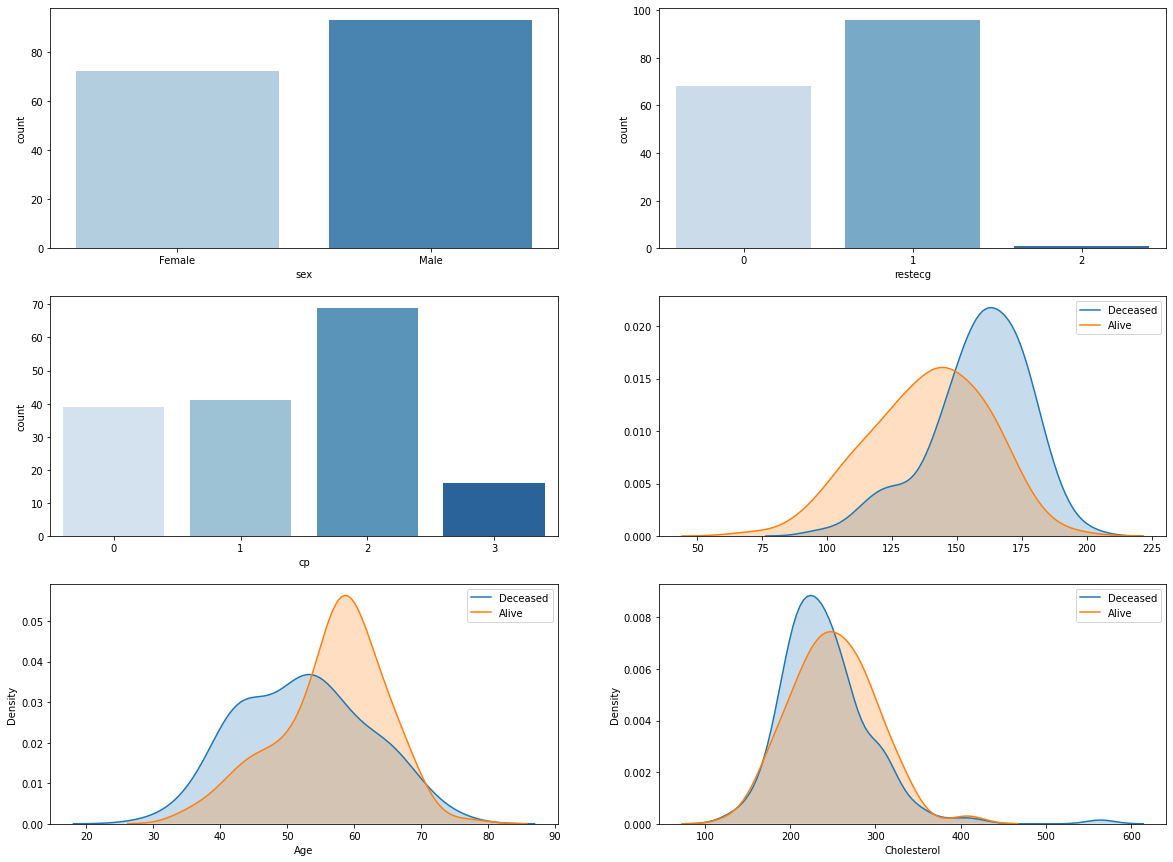

In [145]:
fig, axes = plt.subplots(3,2, figsize=(20,15))
sns.countplot(data=data[data['target']==1], x='sex', ax=axes[0][0], palette='Blues')
axes[0][0].set_xticklabels(['Female', 'Male'])
sns.countplot(data=data[data['target']==1], x='restecg', ax=axes[0][1], palette='Blues')

sns.countplot(data=data[data['target']==1], x='cp', ax=axes[1][0], palette='Blues')
sns.kdeplot(data[data['target'] == 1]['thalach'].rename('Deceased'), ax=axes[1][1], shade=True)
sns.kdeplot(data[data['target'] == 0]['thalach'].rename('Alive'), ax=axes[1][1], shade=True)

sns.kdeplot(data[data['target'] == 1]['age'].rename('Deceased'), ax=axes[2][0], shade=True)
sns.kdeplot(data[data['target'] == 0]['age'].rename('Alive'), ax=axes[2][0], shade=True)
axes[2][0].set_xlabel('Age')
axes[2][0].set_ylabel('Density')

sns.kdeplot(data[data['target'] == 1]['chol'].rename('Deceased'), ax=axes[2][1], shade=True)
sns.kdeplot(data[data['target'] == 0]['chol'].rename('Alive'), ax=axes[2][1], shade=True)
axes[2][1].set_xlabel('Cholesterol')
axes[2][1].set_ylabel('Density')


Males with a restecg = 1 and chest pain type = 1 are more likely to pass away due to heart failure

## Modelling
Following supervised learning models will be tested:
* Logistic Regression
* Random Forest Classifier
* Gradient Boosting Model Classifier

### Baseline model
* Use all features with default hyperparameters to generate baseline results
* Create a modelData function to quickly generate baseline models for different modelling approaches

In [146]:
def modelData(model ,data, features, test_size):
    """
    Splits data into train and test datasets and models data using default model hyper parameters
    
    Inputs
        model: Model Class 
        data: Dataframe containg all feature and target data
        features: Features to be included in model
        test_size: desired training split size
    
    Return
        Model accuracy
    """
    
    target = data['target']
    features = data[features]
    X_train, X_test, y_train, y_test = train_test_split(data.iloc[:,:-1], data.iloc[:,-1], test_size=test_size, random_state=42)
    m_fit = model.fit(X_train, y_train)
    m_predict = model.predict(X_test)
    score = accuracy_score(m_predict, y_test)
    
    return score

In [147]:
models = [RandomForestClassifier(), GradientBoostingClassifier(), LogisticRegression(max_iter=1000)]
models_name = ['RandomForest', 'GradientBoost', 'LogisticRegression']
baseline_scores = []

for model in models:
    score = modelData(model,data,data.columns[:-1], 0.3)
    baseline_scores.append(score)
baseline_results = pd.DataFrame(list(zip(models_name,baseline_scores)),columns=['Model','Score'])
baseline_results

,Model,Score
0,RandomForest,0.813187
1,GradientBoost,0.780220
2,LogisticRegression,0.813187


In [148]:
data.columns[:-1]

Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal'],
      dtype='object')

### Feature Selection
* Understand correlation of features with target and only keep features highly correlated with target
* Heatmap to understand correlation between each feature for feature selection. Remove any features that are highly correlated

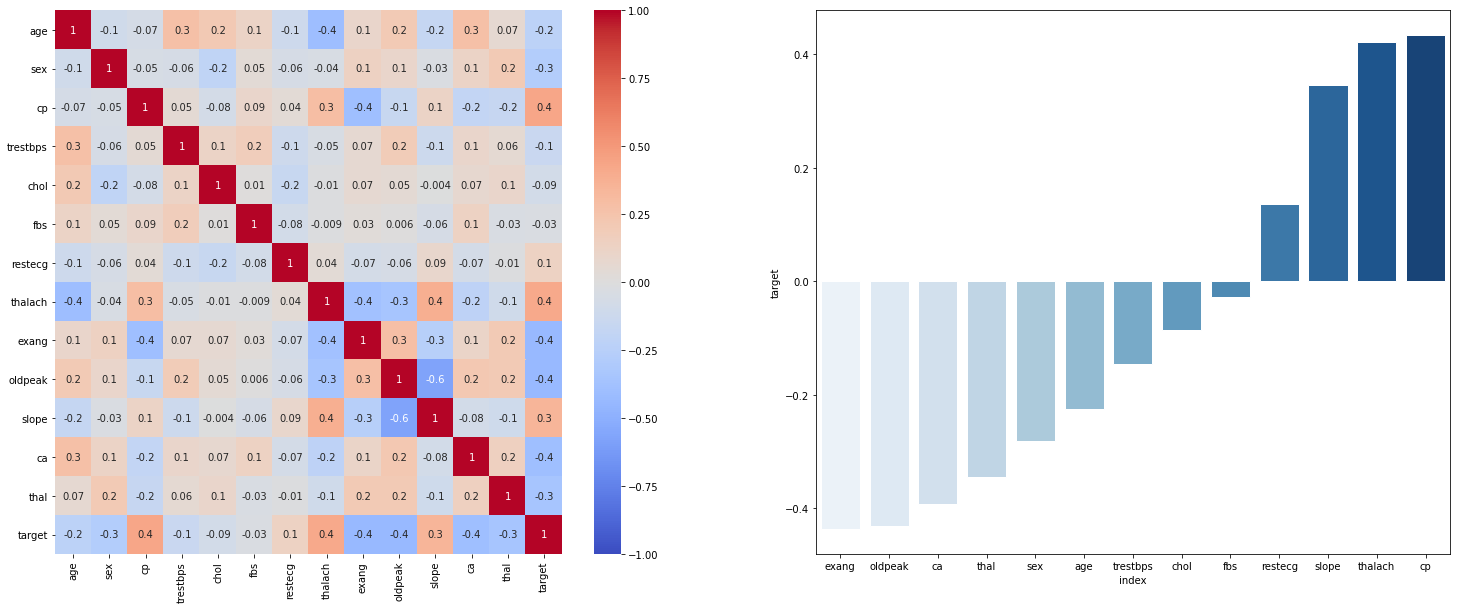

In [149]:
fig, axes = plt.subplots(1,2,figsize=(25,10))
data_corr = pd.DataFrame((data.corr(method='pearson')['target']).drop('target')).reset_index().sort_values(by='target')
sns.barplot(data=data_corr, x='index', y='target', palette = 'Blues', edgecolor = 'w', ax=axes[1])
sns.heatmap(data.corr(), annot=True, fmt='.1g', vmin=-1, vmax=1, center=0, cmap='coolwarm', ax=axes[0])

Using the heatmap and correlation barplot, highly correlated features were removed to reduce multicollinearity. Only the top 4 highly correlated features with the target were selected
* cp
* thalach
* oldpeak
* sex

In [150]:
subset = ['cp', 'thalach', 'oldpeak', 'sex']
it1_scores = []

for model in models:
    score = modelData(model,data,subset,0.3)
    it1_scores.append(score)
it1_results = pd.DataFrame(list(zip(models_name,baseline_scores,it1_scores)),columns=['Model','Baseline','It1'])
it1_results

,Model,Baseline,It1
0,RandomForest,0.813187,0.802198
1,GradientBoost,0.780220,0.780220
2,LogisticRegression,0.813187,0.813187


### Logistic Regression
Logistic regression is used to model the probability of a certain class or event existing. It is used when the dependent variables (target) is categorical eg. Pass/Fail.  

**Types of logistic regression problems:**    
* *Binary*: Most popular type of problem to use for logistic regression. Response only has two possible outcomes eg. Predicting whether a bank customer will churn eg. Churn/No Churn
* *Multinominal Logistic Regression*: Three or more categories without ordering eg. Predicting which mode of transferred is preferred eg. Walk, Train, Bus
* *Ordinal Logistic Regression*: Three or more categories with ordering eg. Movie rating 1-5  

**Logistic Regression equation:**  
* y = e^(b0 + b1*x) / (1 + e^(b0 + b1*x))  

The coefficients (Beta values b) of the logistic regression algorithm is estimated from the training data using the Maximum Likelihood estimation. Maximum likelihood estimation(MLE) is a method that will find the values of μ and σ that result in the curve that best fits the data.  
Reference: https://towardsdatascience.com/probability-concepts-explained-maximum-likelihood-estimation-c7b4342fdbb1

In [166]:
## Using all features
X_1_train, X_1_test, y_1_train, y_1_test = train_test_split(data.iloc[:,:-1], data.iloc[:,-1],test_size=0.3,random_state=42)
m_1 = LogisticRegression(max_iter=1000)
m_1_fit = m_1.fit(X_1_train, y_1_train)
m_1_predict = m_1.predict(X_1_test)
print('Accuracy using all features {:.2f}'.format(accuracy_score(m_1_predict, y_1_test)))


## Using SelectKBest method
X_new = SelectKBest(chi2, k=5).fit(X_1_train, y_1_train)
mask = X_new.get_support(indices=True)
X_2_train, X_2_test, y_2_train, y_2_test = train_test_split(data.iloc[:,mask], data.iloc[:,-1],test_size=0.3,random_state=42)
m_2 = LogisticRegression()
m_2_fit = m_2.fit(X_2_train, y_2_train)
m_2_predict = m_2.predict(X_2_test)
print('Accuracy using SelectKBest top 5 features {:.2f}'.format(accuracy_score(m_2_predict, y_2_test)))

## Using subset of features
X_3_train, X_3_test, y_3_train, y_3_test = train_test_split(data[subset], data.iloc[:,-1],test_size=0.3,random_state=42)
m_3 = LogisticRegression(max_iter=1000)
m_3_fit = m_3.fit(X_3_train, y_3_train)
m_3_predict = m_3.predict(X_3_test)
print('Accuracy using manual selection of top {} features {:.2f}'.format(len(subset),accuracy_score(m_3_predict, y_3_test)))

Accuracy using all features 0.81
Accuracy using SelectKBest top 5 features 0.82
Accuracy using manual selection of top 4 features 0.86


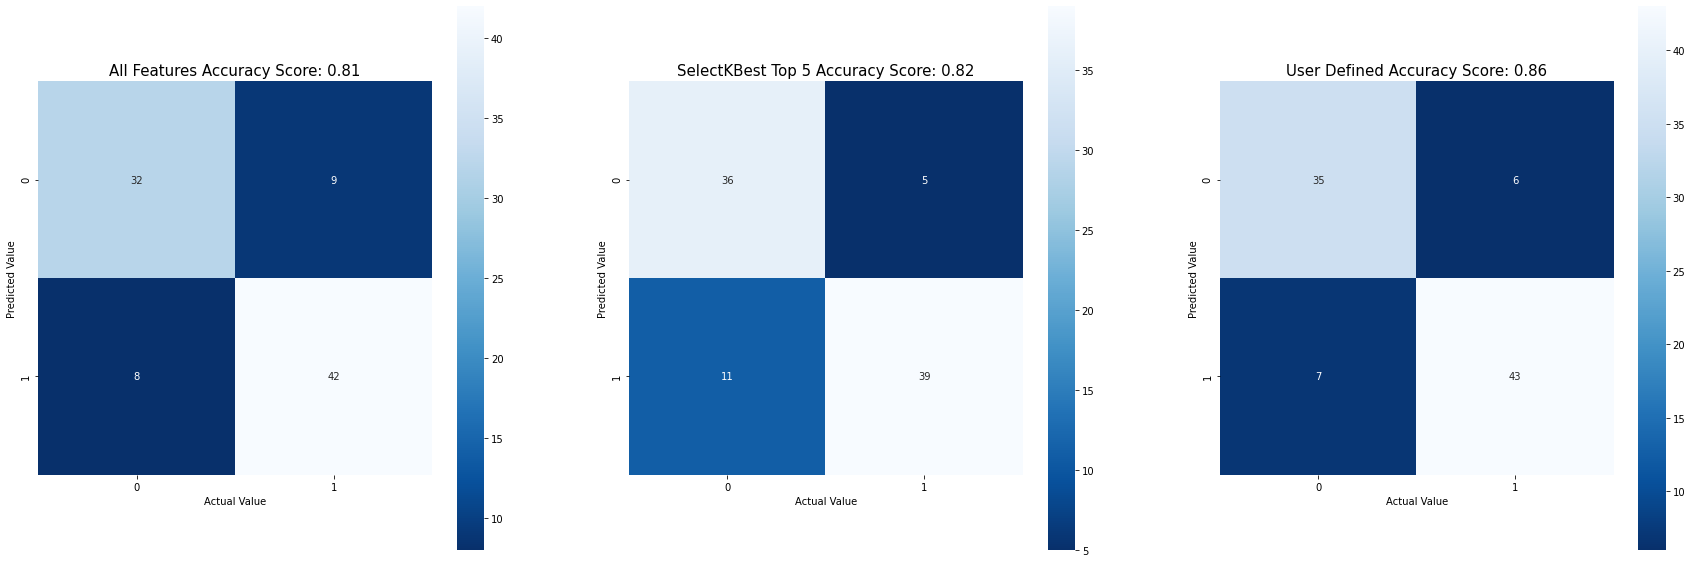

In [152]:
fig, axes = plt.subplots(1,3, figsize=(30,10))
it = [y_1_test, y_2_test, y_3_test]
pred = [m_1_predict, m_2_predict, m_3_predict]
title = ['All Features', 'SelectKBest Top 5', 'User Defined']

for i in range(0,3):
    cm = confusion_matrix(it[i], pred[i])
    sns.heatmap(cm, annot=True, fmt='.0f',cmap='Blues_r',square=True, ax=axes[i])
    axes[i].set_xlabel('Actual Value')
    axes[i].set_ylabel('Predicted Value')
    all_sample_title = '{} Accuracy Score: {:.2f}'.format(title[i],accuracy_score(pred[i], it[i]))
    axes[i].set_title(all_sample_title, size = 15);

## Random Forest Classifier
### **Overview**
### **Feature Selection**
### **Baseline model**
### **Feature Engineering**
### **Hyperparameters and model validation**
**Overview**  
Hyperparameters are model parameters that can be adjusted prior to the training process. Different models have different hyperparameters. Following four hyperparameters will be tuned for our RF model:  
   1. **n_estimators:** The n_estimators parameter specifies the number of trees in the forest of the model. The default value for this parameter is 10, which means that 10 different decision trees will be constructed in the random forest.
   2. **max_depth:** The max_depth parameter specifies the maximum depth of each tree. The default value for max_depth is None, which means that each tree will expand until every leaf is pure. A pure leaf is one where all of the data on the leaf comes from the same class.
   3. **min_samples_split:** The min_samples_split parameter specifies the minimum number of samples required to split an internal leaf node. The default value for this parameter is 2, which means that an internal node must have at least two samples before it can be split to have a more specific classification.
   4. **min_samples_leaf:** The min_samples_leaf parameter specifies the minimum number of samples required to be at a leaf node. The default value for this parameter is 1, which means that every leaf must have at least 1 sample that it classifies.  
   
Evaluating hyperparameter tuning on training set may lead to overfitting hence must always be evaluated using the test set.  
Cross-Validation may be used to test hyperparameters, with each cross-validation process using differing hyperparameters. In Cross-Validation, we split the training dataset into K-Folds. For example if we split the training set into 5 even folds, then 4 will be used for training and 1 will be used for testing. k times. At the very end of training, we average the performance on each of the folds to come up with final validation metrics for the model.  

**Hyper Paramter tuning approach**  
One disadvantage of using a holdout set for model validation is that we have lost a portion of our data to the model training. In the above case, half the dataset does not contribute to the training of the model! This is not optimal, and can cause problems – especially if the initial set of training data is small. One way to address this is to use **cross-validation**;  

**Validation Curve**: Used to compare Feature parameter (n_estimators, Polynomials, min_samples_leaf) vs Score for training and validation datasets for understand bias-variance tradeoff, where bias (underfitting) and variance (overfitting)   

**RandomizedSearchCV:** Random search allowed us to narrow down the range for each hyperparameter.  

**GridSearchCV:** Now that we know where to concentrate our search, we can explicitly specify every combination of settings to try. We do this with GridSearchCV, a method that, instead of sampling randomly from a distribution, evaluates all combinations we define.


Reference: 
* https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74  
* https://jakevdp.github.io/PythonDataScienceHandbook/05.03-hyperparameters-and-model-validation.html

In [165]:
# RF baseline model accuracy using default RF hyperparameters
X_train, X_test, y_train, y_test = train_test_split(data.iloc[:,:-1], data.iloc[:,-1],test_size=0.3,random_state=42)
m = RandomForestClassifier()
m_fit = m.fit(X_train, y_train)
m_predict = m.predict(X_test)
score = accuracy_score(m_predict, y_test)
print('RF baseline model accuracy: {:.4f}'.format(score))

RF baseline model accuracy: 0.8242


### Validation Curve

Reference: https://scikit-learn.org/stable/modules/learning_curve.html

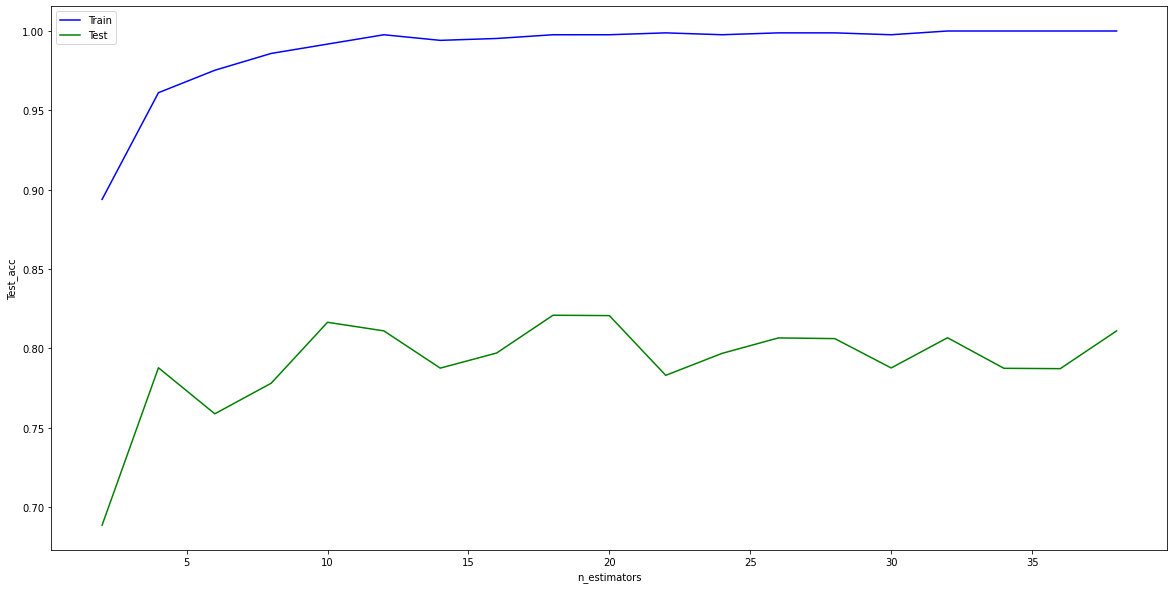

In [154]:
n_estimators_results_test=[]
n_estimators_results_train=[]
train_scoreNum, test_scoreNum = validation_curve(
                                RandomForestClassifier(),
                                X = X_train, y = y_train, 
                                param_name = 'n_estimators', 
                                param_range = np.arange(2,40,2), cv = 5)
n_estimators_results_train.append([np.mean(a) for a in train_scoreNum])
n_estimators_results_test.append([np.mean(a) for a in test_scoreNum])
n_estimators_train = pd.DataFrame(list(zip(n_estimators_results_train[0],n_estimators_results_test[0],np.arange(2,40,2))),columns=['Train_acc','Test_acc', 'n_estimators'])
sns.lineplot(x='n_estimators',y='Train_acc',data=n_estimators_train, color='b')
sns.lineplot(x='n_estimators',y='Test_acc',data=n_estimators_train, color='g')
plt.legend(['Train', 'Test'])

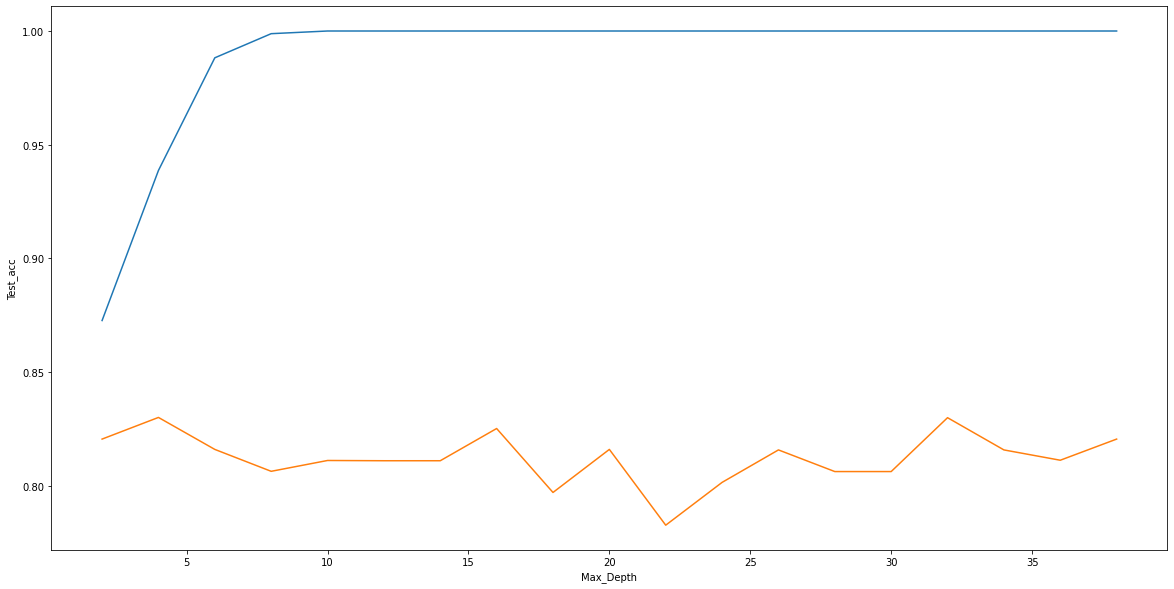

In [155]:
max_depth_train=[]
max_depth_test=[]
train_scoreNum, test_scoreNum = validation_curve(
                                RandomForestClassifier(),
                                X = X_train, y = y_train, 
                                param_name = 'max_depth', 
                                param_range = np.arange(2,40,2), cv = 5)
max_depth_train.append([np.mean(a) for a in train_scoreNum])
max_depth_test.append([np.mean(a) for a in test_scoreNum])
max_depth_vc = pd.DataFrame(list(zip(max_depth_train[0],max_depth_test[0],np.arange(2,40,2))),columns=['Train_acc','Test_acc', 'Max_Depth'])
sns.lineplot(x='Max_Depth',y='Train_acc',data=max_depth_vc)
sns.lineplot(x='Max_Depth',y='Test_acc',data=max_depth_vc)

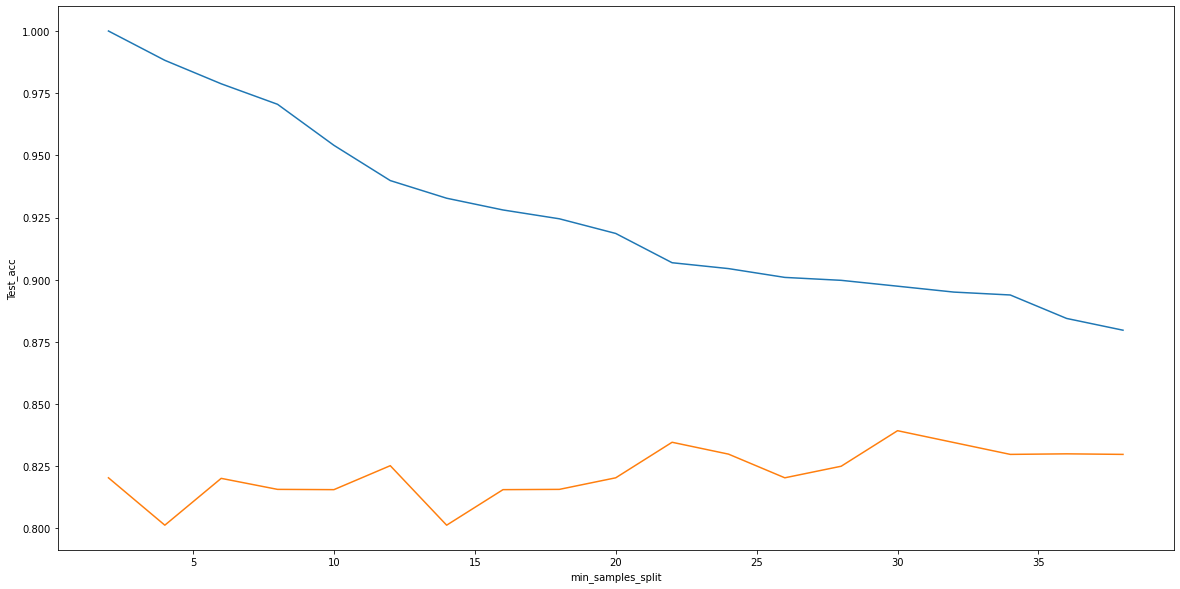

In [156]:
max_depth_train=[]
max_depth_test=[]
train_scoreNum, test_scoreNum = validation_curve(
                                RandomForestClassifier(),
                                X = X_train, y = y_train, 
                                param_name = 'min_samples_split', 
                                param_range = np.arange(2,40,2), cv = 5)
max_depth_train.append([np.mean(a) for a in train_scoreNum])
max_depth_test.append([np.mean(a) for a in test_scoreNum])
max_depth_vc = pd.DataFrame(list(zip(max_depth_train[0],max_depth_test[0],np.arange(2,40,2))),columns=['Train_acc','Test_acc', 'min_samples_split'])
sns.lineplot(x='min_samples_split',y='Train_acc',data=max_depth_vc)
sns.lineplot(x='min_samples_split',y='Test_acc',data=max_depth_vc)

In [157]:
m = RandomForestClassifier(n_estimators=18,max_depth=14,min_samples_split=20)
cross_val_score(m,X_train,y_train,cv=5)
m_fit = m.fit(X_train, y_train)
m_predict = m.predict(X_test)
score = accuracy_score(m_predict, y_test)
print('Validation curve model accuracy: {:.4f}'.format(score))

Validation curve model accuracy: 0.8242


### GridSearchCV
GridSearch allows users to expliciity specify every combination of hyperparameters to try. This differs from RandomizedGridSearch in that instead of sampling randomly from a distribution, the method evaluates all combinations we define

In [158]:
# Defining Grid for Grid Search
param_grid = {'bootstrap': [True], #Sample with random subset of data with replacement
              'n_estimators': np.arange(2,20,2),
              'max_depth': np.arange(2,20,2),
              'min_samples_split': np.arange(2,20,2),
              'min_samples_leaf': np.arange(16,24,2)  
}
# Create RandomForestRegressor Variable
m = RandomForestClassifier()
grid_search = GridSearchCV(estimator = m, param_grid = param_grid, cv=3, n_jobs = -1, verbose = 2)

In [159]:
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 2916 candidates, totalling 8748 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 956 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done 2580 tasks      | elapsed:   28.7s
[Parallel(n_jobs=-1)]: Done 4844 tasks      | elapsed:   52.7s
[Parallel(n_jobs=-1)]: Done 7764 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 8748 out of 8748 | elapsed:  1.6min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,...
                                              random_state=None, verbose=0,
                                   

In [160]:
grid_search.best_params_

{'bootstrap': True,
 'max_depth': 18,
 'min_samples_leaf': 16,
 'min_samples_split': 16,
 'n_estimators': 12}

In [162]:
m = RandomForestClassifier(n_estimators=12,max_depth=18,min_samples_split=16, min_samples_leaf=16)
#cross_val_score(m,X_train,y_train,cv=5)
m_fit = m.fit(X_train, y_train)
m_predict = m.predict(X_test)
score = accuracy_score(m_predict, y_test)
print('Grid Search model accuracy: {:.4f}'.format(score))

Grid Search model accuracy: 0.8462


# Conclusion
Logistic Regression with the top 4 features selected based on correlation with target returned the greatest accuracy at 86%
Random Forest Classifier, an ensemble method that used the same 4 features with tuned hyperparameters resulted in an accuracy or 84.62%